<a href="https://colab.research.google.com/github/tamal2000/Capstone-Project/blob/master/Capstone_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Capstone Project - The Battle of Neighborhoods***
---
**Finding Apartment in the emerging Neighborhoods of Utrecht, NL**

#Background:

<p>I have recently moved to Utrecht, Netherlands for my higher masters. Utrecht is a very beautiful and nice city in Netherland which is only 20 minutes intercity train ride away from Amsterdam. As Amsterdam is one of the most visited cities of the world by the tourists, the inhabitant of the Netherlands likes to stay away from the busy city centre and live in a quieter and peaceful place like Utecht. Not only the commute to Utrecht from most of the major cities is very good, but the city is also very popular for different cultural activates, events, universities, parks, bars and restaurants. As a result, the demand for an apartment rental is very high in Utrecht.<p>

<p>A large number of expat and locals are always looking for suitable housing in Utrecht. The target of this project will help all the apartment hunters to find a suitable apartment or house based on the budget in the emerging neighborhoods of Utecht by data-driven analysis. <p>

At a glance a target audience will able to get benefited from the below feature of this project:

* Finding the emerging neighbourhoods in Utecht, NL 
* Compare between these new neighbourhoods 
* Rent compare the apartments based on their size, rooms and the location in the new neighbourhood clusters
* Finally selecting top apartments based on budget, location preference etc. 



#Libraries 
Importing all the necessary libraries to do this machine learning project

In [5]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import breautiful soup to scrap data from websites 
from bs4 import BeautifulSoup 
from urllib.request import Request, urlopen

# importing geopy library to find the geo location and distance 
from geopy.geocoders import Nominatim 
import geopy.distance

# google library for mounting google drive for data backup
from google.colab import drive

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 

# importing folim library for visual maps
import folium

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


#Data Acquisition:

Rental data: I used the most popular rental website www.pararius.com to collect the available rental locations in Utrecht. The rental data helped me analysis the price based on geographical location, size and other facilities.  Below data fields were collected for analysis. 
* Title, 
Type, 
Postcode, 
Neighbourhood, 
size, 
Rooms, 
Furnished 
and Rent

Venue Data: 
I used the Foursquare API to collect venue data. This data was used to find the upcoming neighbourhood in Utrecht. Below data fields were collected by using this API. 
* Neighbourhood, 
Venues, 
Venue Latitude, 
Venue Longitude,
and Venue Catagory  

Location Data: 
Neighbourhood data: To get geolocation along with Neighborhood of Utrecht I had to collect it from multiple pages from Postcodebijadres.nl. In the first step, I have collected Utrecht districts and then collected all neighbourhood data in each district. Below fields were collected for this. 
* District, 
Neighbourhood
Neighbourhood Latitude
Neighbourhood Longitude 

Postcode data: The site Postcodebijadres.nl also had geolocation for each postcode which was very useful to find the geolocation of each rental places. So instead of using google geo API to collect latitude and longitude of each apartment, I have collected geolocation for each postcode situated in Utrecht, NL. below are the main fields which were collected.
* Postcode,
Neighbourhood, 
Latitude 
And Longitude 


##Rental Data collection

Rental data has been collected from www.pararius.com by using BeatifulSoup Library. The rental information was saturated in a total of 14 pages of the website. By crawling through each page I have collected title, rental type, postcode, neighbourhood, number of rooms, furnished and rent. below code were executed to collect the rental information.

In [0]:
file_rent = 'utrecht_rentals.csv'
f_rent = open(file_rent, "w")
headers ="rental_title, rental_type, rental_post, rental_neigh, rent, rental_size, rental_room, rental_furnished\n"

f_rent.write(headers)
a = 1 #counter used to travers through each pages of the website
while a <= 14:
  url_rent = 'https://www.pararius.com/apartments/utrecht/page-{}'.format(a)
  req_rent = Request(url_rent , headers={'User-Agent': 'Mozilla/5.0'})
  web_rent = urlopen(req_rent).read()
  rent_soup = BeautifulSoup(web_rent, "html.parser")
  rentals = rent_soup.find_all('div',{'class':'details'})

  try:
    for rental in rentals:
      headline = rental.h2
      rental_title = headline.span.next_sibling.strip().replace("\n", "").replace('  ', '')
      rental_type = rental.h2.span.text
      rental_post = rental.find('li').find('li').previous_sibling.replace(' ', '').strip()
      rental_neigh = rental.find('li').find('li').find('li').text.strip()
      rent = rental.find('p', {'class':'price'}).text.strip().replace(',','').split()[0][1:]
      rental_size = rental.find('li',{'class':'surface'}).li.previous_sibling.split()[0].strip()
      rental_room = rental.find('li',{'class':'surface'}).li.text.split()[0]
      rental_furnished = rental.find('li',{'class':'surface'}).li.text.split()[2]
      f_rent.write(rental_title + ',' + rental_type + ',' + str(rental_post) + ',' + rental_neigh + ',' + str(rent) + ',' + str(rental_size) + ',' + str(rental_room) + ',' + rental_furnished+'\n')
  except:
    pass
  
  a += 1

f_rent.close()
print('Utrecht rental information has been collected using BeautifulSoup')

##Neigbourhood data aquisition
> step 1: Purse the www.postcodebijadres.nl using BeautifulSoup library<br>
> Step 2: Then collected the list of District in Utecht, NL <br>
> Step 3: Then from each district collect the district geolocation and Neighbourhood list<br>
> Step 4: Collect geolocation of each neighbourhood. 

Below source code has been used to collect neighbourhood details

In [0]:
#Purse utrecht page using beautifiulSoup

url = 'https://postcodebijadres.nl/gemeente/utrecht'
req = Request(url , headers={'User-Agent': 'Mozilla/5.0'})

web_utrecht = urlopen(req).read()
utrecht_soup = BeautifulSoup(web_utrecht, "html.parser")

print('Utrecht page has been prossesed by BeautifulSoup')

Utrecht page has been prossesed by BeautifulSoup


In [0]:
#Collect all district list in Utrecht 
utrecht_page = utrecht_soup.find_all('a', class_="badge badge-primary")

District_list = []
for district in utrecht_page:
  if district.text.split(' ', 1)[0] == 'Wijk':
    District_list.append(district.text.strip())

print("Utrecht has {} number of Districts".format(len(District_list)))

Utrecht has 11 number of Districts


In [0]:
#Collect Neighbourhood data

filename = 'utrecht_neigh.csv'
f_neigh = open(filename, "w")
headers ="District, District_latitude, District_longitue, Neigbourhood, Neigh_latitude, Neigh_longitude\n"

f_neigh.write(headers)

neigh_url_array = []
streer_array =[]

for dis in District_list:

    url_dis = 'https://postcodebijadres.nl/gemeente/utrecht/wijk/{}'.format(dis.replace(" ","-"))
    
    #purse each district location though Beautiful soup
    req0 = Request(url_dis , headers={'User-Agent': 'Mozilla/5.0'})

    web_district = urlopen(req0).read()
    district_soup = BeautifulSoup(web_district, "html.parser")

    try:

      dis_latitude = district_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[0].find_all('td')[1].text
      dis_longitude = district_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[1].find_all('td')[1].text

      neigh_list = district_soup.find_all('div', {'class':'info-block__body'})[1].find_all('a')
      
      for Neigh in neigh_list:
        neigh = Neigh.text.replace(","," |")
        neigh_url = 'https://postcodebijadres.nl/'+ Neigh['href']
          
        #purse neigbourhood page with Beautiful soup 
        req2 = Request(neigh_url , headers={'User-Agent': 'Mozilla/5.0'})
        web_neigh = urlopen(req2).read()
        neigh_soup = BeautifulSoup(web_neigh, "html.parser")

        try:
          neigh_latitude = neigh_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[0].find_all('td')[1].text
          neigh_longitude = neigh_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[1].find_all('td')[1].text
          #write collected information in the utrecht_neigh.csv file  
          f_neigh.write(dis.replace(",","|") + ','+  str(dis_latitude) +','+ str(dis_longitude) +',' + neigh.replace(",","|")+','+ str(neigh_latitude)+ ',' +str(neigh_longitude)+'\n' )

        except:
          pass
    except:
      pass  

f_neigh.close()
#Neighbourhoods

##Postcode data 
> Similar to above code I have used beautiflul soup library to collect geolocation of each postcode. this data helped me to get latitude and longitude of each rental location instead of using google geo API. 

In [0]:
filename = 'utrecht_postcode_v1.csv'
f_post = open(filename, "w")
headers ="Postcode_Number, District, District_latitude, District_longitue, Neigbourhood, Neigh_latitude, Neigh_longitude, Zipcode,Street, Latitude, longitude\n"

f_post.write(headers)
neigh_url_array = []
streer_array =[]

for dis in District_list:
    
    url_dis = 'https://postcodebijadres.nl/gemeente/utrecht/wijk/{}'.format(dis.replace(" ","-"))
    
    #purse each district location though Beautiful soup
    req0 = Request(url_dis , headers={'User-Agent': 'Mozilla/5.0'})

    web_district = urlopen(req0).read()
    district_soup = BeautifulSoup(web_district, "html.parser")

    try:

      dis_latitude = district_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[0].find_all('td')[1].text
      dis_longitude = district_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[1].find_all('td')[1].text
 
      neigh_list = district_soup.find_all('div', {'class':'info-block__body'})[1].find_all('a')

      for Neigh in neigh_list:
        neigh = Neigh.text.replace(","," |")
        neigh_url = 'https://postcodebijadres.nl/'+ Neigh['href']
          
        req2 = Request(neigh_url , headers={'User-Agent': 'Mozilla/5.0'})

        web_neigh = urlopen(req2).read()
        neigh_soup = BeautifulSoup(web_neigh, "html.parser")

        try:
          neigh_latitude = neigh_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[0].find_all('td')[1].text
          neigh_longitude = neigh_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[1].find_all('td')[1].text
              
          postcode_list = neigh_soup.find('table',{"id":"postcodes-table"}).find_all('tr')

          for a in postcode_list:
            try:
              post_code = a.find('td').text.replace(" ","")
              street_name = a.find('td',{'class':'d-none d-md-table-cell'}).text.strip()
              post_url = 'https://postcodebijadres.nl/'+post_code
              req3 = Request(post_url , headers={'User-Agent': 'Mozilla/5.0'})
              web_post = urlopen(req3).read()
              post_soup = BeautifulSoup(web_post, "html.parser")

              latitude = post_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[0].find_all('td')[1].text
              longitude = post_soup.find_all('table',{'class':'table table-bordered mt-3'})[1].find_all('tr')[1].find_all('td')[1].text
              postcode_number = post_soup.find('table', {'class':'table table-bordered mt-3'}).find_all('tr')[3].find('td').text

              f_post.write(str(postcode_number) + ',' + dis.replace(",","|") + ','+  str(dis_latitude) +','+ str(dis_longitude) +',' + neigh.replace(",","|")+','+ str(neigh_latitude)+ ',' +str(neigh_longitude)+','+str(post_code)+','+street_name.replace(",","|")+','+str(latitude)+','+str(longitude)+'\n' )
              time.sleep(1.5)
              
            except:
              pass
        except:
          pass
    except:
      pass  

f_post.close()

##Data Backup in Google Drive

For perform end ot end analysis on the collected data, it would require me more than a week. Instead of crowling through each pages multiple times, I have deciced to keep the file backup in google drive, so that I can reuse the data whenever it's needed. 

In [7]:
#Mounting my google drive in the virtual environment

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Keep a copy of the Neighbourhood data, Postcode data and retal information in the capstone_project of my Google Drive

!cp utrecht_neigh.csv drive/My\ Drive/capstone_project
!cp utrecht_postcode_v1.csv drive/My\ Drive/capstone_project
!cp utrecht_rentals.csv drive/My\ Drive/capstone_project

print('file backup to google drive has been completed')

file backup to google drive has been completed


In [0]:
#importing files from backup to notebook environment. These process was done multiple time based on I need the data
!cp drive/My\ Drive/capstone_project/utrecht_neigh.csv . 
!cp drive/My\ Drive/capstone_project/utrecht_postcode_v1.csv . 
!cp drive/My\ Drive/capstone_project/utrecht_rentals.csv .

## Importing to Pandas Dataframe
Importing collected information in the respecting pandas datafram

In [0]:
#Defining the headers and and importing neighbourhood, postcode and rental deta in the below pandas dataframe

df_rental = pd.read_csv("utrecht_rentals.csv", header=0, names=['Title', 'Type', 'Postcode','Neighborhood','Rent','Size','Rooms','Furnished']) 
df_neigh = pd.read_csv("utrecht_neigh.csv",  header=0, names=['District', 'DLatitude', 'DLongitude','Neighborhood','Latitude','Longitude']) 
df_post = pd.read_csv("utrecht_postcode_v1.csv",  header=0, names=['PostCode Number', 'District', 'DLatitude', 'DLongitude','Neighborhood','NLatitude','NLongitude','PostCode', 'Street', 'SLatitude', 'SLongitude']) 

In [10]:
#Viewing the Rentail information
df_rental.head(5)

,Title,Type,Postcode,Neighborhood,Rent,Size,Rooms,Furnished
0,Van Heesstraat,Apartment,3555GH,Noordwest,1250,55,1,upholstered
1,Abstederdijk,House,3582BE,Oost,1250,75,2,furnished
2,Hildebranddreef,Room,3561VD,Overvecht,49,27,1,furnished
3,Nieuwekade,Apartment,3511RW,Binnenstad,1590,72,2,furnished
4,Adelaarstraat,Apartment,3514CH,Noordoost,1495,75,2,furnished


In [11]:
#viewing Neighbourhood datafram
df_neigh.head(5)

,District,DLatitude,DLongitude,Neighborhood,Latitude,Longitude
0,Wijk 00 Bunnik,52.061679,5.185625,Bunnik,52.068070,5.201628
1,Wijk 00 Bunnik,52.061679,5.185625,Vechten,52.064471,5.172355
2,Wijk 00 Bunnik,52.061679,5.185625,Verspreide huizen in het noorden,52.071684,5.171363
3,Wijk 00 Bunnik,52.061679,5.185625,Verspreide huizen in het zuiden,52.054542,5.183541
4,Wijk 01 West,52.105072,5.071596,Welgelegen | Den Hommel,52.082837,5.089841


In [12]:
#Viewing postcode data
df_post[['PostCode', 'Neighborhood', 'Street', 'SLatitude', 'SLongitude']].head()

,PostCode,Neighborhood,Street,SLatitude,SLongitude
0,3981AA,Bunnik,Stationsweg,52.064300,5.205860
1,3981AB,Bunnik,Stationsweg,52.066078,5.202329
2,3981AC,Bunnik,Stationsweg,52.064279,5.206843
3,3981AD,Bunnik,Stationsweg,52.065852,5.204077
4,3981AE,Bunnik,Schoudermantel,52.062812,5.209969


#Explore Neighbourhood data

From the Neighbourhood dataframe we can find total districts and neighbourhoods and explore the details by superimposing the map using folium librery

In [13]:
df_neigh
print('The dataframe has {} districts and {} neighborhoods.'.format(len(df_neigh['District'].unique()),df_neigh.shape[0]))

The dataframe has 11 districts and 113 neighborhoods.


In [14]:
#lets find the geo coordinance of Utrecht using Nominatim method of geocode library
address = 'Utrecht Station, Netherlands'
geolocator = Nominatim(user_agent="utrecht_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Utrecht are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Utrecht are 52.0809856, 5.12768396945229.


In [15]:
#Creating map of the Utrecht with superimpossing the Districts  
utrecht_map = folium.Map(location=[latitude, longitude], zoom_start=12, width=850,height=500)
folium.vector_layers.CircleMarker([latitude,longitude], radius= 135, color ='purple',fill=True).add_to(utrecht_map)
folium.vector_layers.CircleMarker([latitude,longitude], radius= 2, color ='red',fill=True).add_to(utrecht_map)
for lat, lng, bor in zip(df_neigh.DLatitude, df_neigh.DLongitude, df_neigh.District):
    label = '{}'.format(bor)
    label = folium.Popup(label, parse_html=True)
    try:
      folium.CircleMarker(
          [lat, lng],
          radius=5,
          popup=label,
          color='blue',
          fill=True,
          fill_color='#3186cc',
          fill_opacity=0.7,
          parse_html=False).add_to(utrecht_map)  
        
    except:pass
utrecht_map

In [16]:
# Let us find the list of Districts
df_neigh.District.unique()

array(['Wijk 00 Bunnik', 'Wijk 01 West', 'Wijk 02 Noordwest',
       'Wijk 03 Overvecht', 'Wijk 04 Noordoost', 'Wijk 05 Oost',
       'Wijk 06 Binnenstad', 'Wijk 07 Zuid', 'Wijk 08 Zuidwest',
       'Wijk 09 Leidsche Rijn', 'Wijk 10 Vleuten-De Meern'], dtype=object)

<h3>It is essential to live near by the central station as commute to other town become easy. Hence for our hunting let us only consider the districts near to central location

In [17]:
#making a new data frame by only taking the neighbourhood closed the central station

df_centre = df_neigh[(df_neigh.District =='Wijk 04 Noordoost') | (df_neigh.District =='Wijk 05 Oost') | (df_neigh.District =='Wijk 06 Binnenstad')| (df_neigh.District =='Wijk 07 Zuid')| (df_neigh.District =='Wijk 08 Zuidwest')] .reset_index(drop = True)
df_centre.head()

,District,DLatitude,DLongitude,Neighborhood,Latitude,Longitude
0,Wijk 04 Noordoost,52.103929,5.136313,Vogelenbuurt,52.098712,5.119590
1,Wijk 04 Noordoost,52.103929,5.136313,Lauwerecht,52.102257,5.113610
2,Wijk 04 Noordoost,52.103929,5.136313,Staatsliedenbuurt,52.103608,5.116502
3,Wijk 04 Noordoost,52.103929,5.136313,Tuinwijk-West,52.103556,5.120480
4,Wijk 04 Noordoost,52.103929,5.136313,Tuinwijk-Oost,52.101237,5.125575


In [18]:
print('total number of neighbourhoods in Urecht Central location are {}'.format(df_centre.shape[0]))

total number of neighbourhoods in Urecht Central location are 50


<h3>Below codes desmostrate that selected dataset does not have any duplicate or null value. 

In [19]:
df_centre.isnull().sum()

District        0
DLatitude       0
DLongitude      0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

In [20]:
df_centre.duplicated().sum()

0

In [21]:
# create map of Utrecht Centre using latitude and longitude values
map_centre = folium.Map(location=[latitude, longitude], zoom_start=13, width=850,height=600 )

for lat, lng, label in zip(df_centre['Latitude'], df_centre['Longitude'], df_centre['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_centre)  
    
map_centre

# Venue Data Collection:

To find the emerging neighbourhoods in Utrecht, I need to find the popular venue information in the Utrecht area. For this, I have used the FourSquare API to collect the required information. First, I have selected the required districts. Then based on each district I have used the neighbourhood geolocation to find the most popular venues in each neighbourhood.  Below data fields were collected by using this API. 

In [0]:
#Define Foursqaure credentials 
client_id = "01CQBBYWIT34RBAPCGAIGAMDN0UFVKIOQKX0S2RM3W2JQM5O"
client_secret = "P52MMA4ITXWNBQ0MQVEIVBKYUBNIPIG1B0DH4GXJLAJVOO1Z"
version = "20180604"

In [32]:
#explore the first neighborhood in Center

df_centre.Neighborhood[0]

'Vogelenbuurt'

In [33]:
#get ll for Vogelenbuurt
neighborhood_name = df_centre.loc[0,'Neighborhood']
neighborhood_latitude = df_centre.loc[0,'Latitude']
neighborhood_longitude = df_centre.loc[0,'Longitude']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Vogelenbuurt are 52.098712014323, 5.1195902720534.


In [34]:
#get the top 100 venues that are in Vogelenbuurt

limit = 100
radious = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(client_id, client_secret, neighborhood_latitude, neighborhood_longitude, version, radious,limit )

url


'https://api.foursquare.com/v2/venues/explore?client_id=01CQBBYWIT34RBAPCGAIGAMDN0UFVKIOQKX0S2RM3W2JQM5O&client_secret=P52MMA4ITXWNBQ0MQVEIVBKYUBNIPIG1B0DH4GXJLAJVOO1Z&ll=52.098712014323,5.1195902720534&v=20180604&radius=500&limit=100'

In [35]:
results = requests.get(url).json()
results['response']['groups'][0]['items'][0]

{'reasons': {'count': 0,
  'items': [{'reasonName': 'globalInteractionReason',
    'summary': 'This spot is popular',
    'type': 'general'}]},
 'referralId': 'e-0-4bbc6b04e436ef3bab795664-0',
 'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
     'suffix': '.png'},
    'id': '4bf58dd8d48988d163941735',
    'name': 'Park',
    'pluralName': 'Parks',
    'primary': True,
    'shortName': 'Park'}],
  'id': '4bbc6b04e436ef3bab795664',
  'location': {'address': 'Blauwkapelseweg',
   'cc': 'NL',
   'city': 'Utrecht',
   'country': 'Nederland',
   'crossStreet': 'Griftstraat',
   'distance': 136,
   'formattedAddress': ['Blauwkapelseweg (Griftstraat)',
    '3572 KC Utrecht',
    'Nederland'],
   'labeledLatLngs': [{'label': 'display',
     'lat': 52.09804384601744,
     'lng': 5.121263817953034}],
   'lat': 52.09804384601744,
   'lng': 5.121263817953034,
   'neighborhood': 'Vogelenbuurt',
   'postalCode': '3572 KC',
   'state': 'Utre

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Griftpark,Park,52.098044,5.121264
1,Garagebedrijf Autoweerd,Auto Garage,52.097323,5.120107
2,Guusjes Eten & Drinken,Bistro,52.100043,5.121283
3,EKKO,Music Venue,52.097525,5.114554
4,'t Zusje,Tapas Restaurant,52.096298,5.117788


In [38]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

31 venues were returned by Foursquare.


In [0]:
#function to repeat the same process to all the neighborhoods in Utrecht Central

nearby_venues = []
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    try:

      for name, lat, lng in zip(names, latitudes, longitudes):
          #print(name, latitude, longitude)
              
          # create the API request URL
          url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
              client_id, 
              client_secret, 
              version, 
              lat, 
              lng, 
              radius, 
              limit)
              
          # make the GET request
          results = requests.get(url).json()["response"]['groups'][0]['items']
          
          # return only relevant information for each nearby venue
          venues_list.append([(
              name, 
              lat, 
              lng, 
              v['venue']['name'], 
              v['venue']['location']['lat'], 
              v['venue']['location']['lng'],  
              v['venue']['categories'][0]['name']) for v in results])

      nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
      nearby_venues.columns = ['Neighborhood', 
                    'Neighborhood Latitude', 
                    'Neighborhood Longitude', 
                    'Venue', 
                    'Venue Latitude', 
                    'Venue Longitude', 
                    'Venue Category']
    except:
      print(name)
      #pass

    return(nearby_venues)

In [0]:
utrecht_venues = getNearbyVenues(names=df_centre['Neighborhood'],
                                   latitudes=df_centre['Latitude'],
                                   longitudes=df_centre['Longitude']
                                  )

In [41]:
print(utrecht_venues.shape)
utrecht_venues.head(5)

(1320, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vogelenbuurt,52.098712,5.11959,Griftpark,52.098044,5.121264,Park
1,Vogelenbuurt,52.098712,5.11959,Garagebedrijf Autoweerd,52.097323,5.120107,Auto Garage
2,Vogelenbuurt,52.098712,5.11959,Guusjes Eten & Drinken,52.100043,5.121283,Bistro
3,Vogelenbuurt,52.098712,5.11959,EKKO,52.097525,5.114554,Music Venue
4,Vogelenbuurt,52.098712,5.11959,'t Zusje,52.096298,5.117788,Tapas Restaurant


In [0]:
#Backup the venue data in the google drive for future usage
utrecht_venues.to_csv('utrecht_venues.csv')

In [0]:
!cp utrecht_venues.csv /content/drive/My\ Drive/capstone_project

In [42]:
utrecht_venues.groupby('Neighborhood').count()['Venue']

Neighborhood
Abstede | Tolsteegsingel e.o.                       12
Bedrijvengebied Kanaleneiland                       25
Bleekstraat en omgeving                             40
Bokkenbuurt                                          4
Breedstraat en Plompetorengracht en omgeving       100
Buiten Wittevrouwen                                 34
De Uithof                                            8
Dichterswijk                                        17
Domplein | Neude | Janskerkhof                     100
Galgenwaard en omgeving                             20
Hooch Boulandt                                      30
Hoog-Catharijne NS en Jaarbeurs                     28
Huizingalaan | K. Doormanlaan en omgeving           22
Kanaleneiland-Noord                                  8
Kanaleneiland-Zuid                                   6
L. Napoleonplantsoen en omgeving                     6
Lange Elisabethstraat | Mariaplaats en omgeving    100
Lange Nieuwstraat en omgeving                       

In [43]:
print('There are {} unique categories of venues in Utrecht Central.'.format(len(utrecht_venues['Venue Category'].unique())))

There are 173 unique categories of venues in Utrecht Central.


In [44]:
# one hot encoding
utrecht_onehot = pd.get_dummies(utrecht_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
utrecht_onehot['Neighbourhood'] = utrecht_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [utrecht_onehot.columns[-1]] + list(utrecht_onehot.columns[:-1])
utrecht_onehot = utrecht_onehot[fixed_columns]

utrecht_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Lake,Laser Tag,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Office,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool Hall,Pub,Public Bathroom,Record Shop,Rental Car Location,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Vogelenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Vogelenbuurt,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Vogelenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Vogelenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Vogelenbuurt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [45]:
utrecht_onehot.shape

(1320, 174)

In [46]:
#group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category
utrecht_grouped = utrecht_onehot.groupby('Neighbourhood').mean().reset_index()
utrecht_grouped.head(3)

,Neighbourhood,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Design Studio,Diner,Discount Store,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Lake,Laser Tag,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Office,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool Hall,Pub,Public Bathroom,Record Shop,Rental Car Location,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Abstede | Tolsteegsingel e.o.,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.083333,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.000,0.0,0.083333,0.0,0.083333,0.00,0.0,0.000,0.0,0.0,0.0,0.000,0.083333,0.0
1,Bedrijvengebied Kanaleneiland,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.04,0.000,0.0,0.0,0.040,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.04,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.000,0.0,0.0,0.0,0.040,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.4,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.080000,0.040,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.04,0.000,0.0,0.04,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

In [0]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = utrecht_grouped['Neighbourhood']

for ind in np.arange(utrecht_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(utrecht_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abstede | Tolsteegsingel e.o.,Art Museum,Museum,Café,Planetarium,Theme Park Ride / Attraction,Train Station,Supermarket,Garden,Gym / Fitness Center,Yoga Studio
1,Bedrijvengebied Kanaleneiland,Furniture / Home Store,Gym / Fitness Center,Light Rail Station,Hotel,Breakfast Spot,Harbor / Marina,Italian Restaurant,Kids Store,Martial Arts Dojo,Fish Market
2,Bleekstraat en omgeving,Bar,Coffee Shop,Café,Beer Bar,French Restaurant,Bakery,Supermarket,Concert Hall,Park,Falafel Restaurant
3,Bokkenbuurt,Cosmetics Shop,Bus Stop,Metro Station,Fast Food Restaurant,Convenience Store,Food,Flower Shop,Flea Market,Fish Market,Farmers Market
4,Breedstraat en Plompetorengracht en omgeving,Bar,Restaurant,Coffee Shop,Burger Joint,Italian Restaurant,Café,Sandwich Place,Hotel,Gym,Pub


#Explore Rental locations

In [59]:
df_rental.head()

,Title,Type,Postcode,Neighborhood,Rent,Size,Rooms,Furnished
0,Van Heesstraat,Apartment,3555GH,Noordwest,1250,55,1,upholstered
1,Abstederdijk,House,3582BE,Oost,1250,75,2,furnished
2,Hildebranddreef,Room,3561VD,Overvecht,49,27,1,furnished
3,Nieuwekade,Apartment,3511RW,Binnenstad,1590,72,2,furnished
4,Adelaarstraat,Apartment,3514CH,Noordoost,1495,75,2,furnished


In [159]:
df_rental.shape

(287, 8)

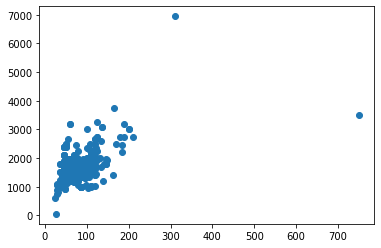

In [60]:
plt.scatter(df_rental.Size, df_rental.Rent)

In [61]:
print("Abnormal Rent in the dataset is {}".format(df_rental.Rent.max()))
print("Abnormal Size in the dataset is {}".format(df_rental.Size.max()))

Abnormal Rent in the dataset is 6950
Abnormal Size in the dataset is 750


In [0]:
df_rental = df_rental[df_rental.Rent != 6950]
df_rental = df_rental[df_rental.Size != 750]

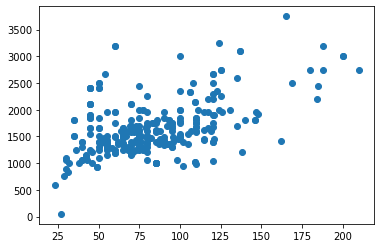

In [64]:
plt.scatter(df_rental.Size, df_rental.Rent)

In [62]:
print(df_rental[df_rental.Rent == 6950])
print(df_rental[df_rental.Size == 750])

          Title            Type Postcode Neighborhood  Rent  Size  Rooms  \
282  Molenmeent  Live workspace   1231KK   Loosdrecht  6950   310      6   

    Furnished  
282   unknown  
            Title   Type Postcode Neighborhood  Rent  Size  Rooms    Furnished
257  Utrechtseweg  House   3732HA      De Bilt  3500   750      6  upholstered


In [65]:
print(df_rental['Furnished'].value_counts())
df_rental['Furnished'].value_counts().idxmax()

furnished      144
upholstered     94
shell           33
unknown         19
Name: Furnished, dtype: int64


'furnished'

In [66]:
df_rental['Furnished'].replace('unknown', 'furnished', inplace=True)
print(df_rental['Furnished'].value_counts())

furnished      163
upholstered     94
shell           33
Name: Furnished, dtype: int64


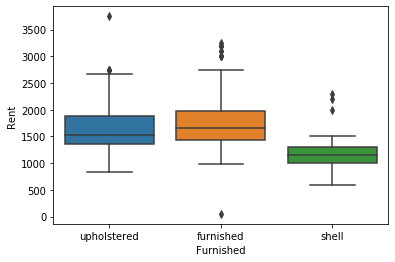

In [67]:
sns.boxplot(x="Furnished", y="Rent", data=df_rental)

In [68]:
print(df_rental['Type'].value_counts())

Apartment    246
House         38
Villa          3
Studio         2
Room           1
Name: Type, dtype: int64


In [0]:
df_rental = df_rental[df_rental.Type != 'Room']

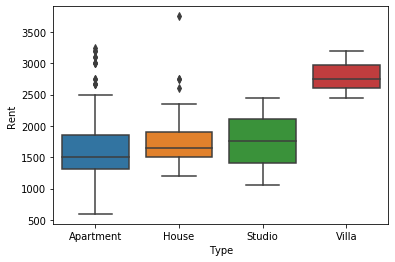

In [70]:
sns.boxplot(x="Type", y="Rent", data=df_rental)

In [71]:
missing_data_after = df_rental.isnull()

for column in missing_data_after.columns.values.tolist():
    print(column)
    print (missing_data_after[column].value_counts())
    print("")   

Title
False    289
Name: Title, dtype: int64

Type
False    289
Name: Type, dtype: int64

Postcode
False    289
Name: Postcode, dtype: int64

Neighborhood
False    285
True       4
Name: Neighborhood, dtype: int64

Rent
False    289
Name: Rent, dtype: int64

Size
False    289
Name: Size, dtype: int64

Rooms
False    289
Name: Rooms, dtype: int64

Furnished
False    289
Name: Furnished, dtype: int64



In [72]:
print(df_rental[df_rental["Neighborhood"].isnull()])

               Title       Type Postcode Neighborhood  Rent  Size  Rooms  \
73   Hollandse Toren  Apartment   3511BN          NaN  1455    99      2   
224  Hollandse Toren  Apartment   3511BN          NaN  1807   146      3   
256  Hollandse Toren  Apartment   3511BN          NaN  1807   146      3   
265  Emmikkerboslaan      Villa   3454NV          NaN  3200   188      5   

     Furnished  
73   furnished  
224  furnished  
256  furnished  
265  furnished  


In [0]:
df_rental.loc[73, 'Neighborhood'] = 'Hollandse Toren'
df_rental.loc[224, 'Neighborhood'] = 'Hollandse Toren'
df_rental.loc[256, 'Neighborhood'] = 'Hollandse Toren'
df_rental.loc[265, 'Neighborhood'] = 'Emmikkerboslaan'

In [74]:

df_rental.sort_values('Postcode', inplace=True)
df_rental.head(5)

,Title,Type,Postcode,Neighborhood,Rent,Size,Rooms,Furnished
279,Egelshoek,Villa,1213RC,Landelijk gebied,2450,185,3,upholstered
268,Nieuw-Loosdrechtsedijk21,Apartment,1231KL,Loosdrecht,1000,46,1,shell
265,Emmikkerboslaan,Villa,3454NV,Emmikkerboslaan,3200,188,5,furnished
62,Zakkendragershof,Apartment,3511AE,Binnenstad,1495,90,2,furnished
208,Zakkendragershof,Apartment,3511AE,Binnenstad,1695,73,3,furnished


In [0]:
df_rental = df_rental[df_rental.Postcode != '1213RC']
df_rental = df_rental[df_rental.Postcode != '1231KL']

In [78]:

len(df_post.PostCode.unique())

8466

In [0]:
df_post = df_post.drop_duplicates(subset='PostCode', keep="first")

In [81]:
merged = df_rental.join(df_post.set_index('PostCode'), on='Postcode', lsuffix='r', rsuffix='p')
merged.shape[0]

287

In [85]:
rental_final= merged[['Title','Postcode','District','Street','Type', 'Size', 'Rooms', 'Furnished', 'Neighborhoodr',  'SLatitude', 'SLongitude','Rent' ]]
rental_central = rental_final[(rental_final.District =='Wijk 04 Noordoost') | (rental_final.District =='Wijk 05 Oost') | (rental_final.District =='Wijk 06 Binnenstad')| (rental_final.District =='Wijk 07 Zuid')| (rental_final.District =='Wijk 08 Zuidwest')] .reset_index(drop = True)

rental_central.head()

,Title,Postcode,District,Street,Type,Size,Rooms,Furnished,Neighborhoodr,SLatitude,SLongitude,Rent
0,Zakkendragershof,3511AE,Wijk 06 Binnenstad,Zakkendragershof,Apartment,90,2,furnished,Binnenstad,52.092719,5.115757,1495
1,Zakkendragershof,3511AE,Wijk 06 Binnenstad,Zakkendragershof,Apartment,73,3,furnished,Binnenstad,52.092719,5.115757,1695
2,Hekelsteeg,3511AK,Wijk 06 Binnenstad,Oudegracht aan de Werf,Apartment,148,2,upholstered,Binnenstad,52.091565,5.118934,1920
3,Oudegracht152-K,3511AZ,Wijk 06 Binnenstad,Oudegracht,Studio,75,1,furnished,Binnenstad,52.091868,5.118060,2450
4,Oudegracht,3511AZ,Wijk 06 Binnenstad,Oudegracht,Apartment,137,1,furnished,Binnenstad,52.091868,5.118060,3100


In [86]:
rental_central.shape

(209, 12)

In [164]:
cluster_map = folium.Map(
    location=[latitude, longitude],
    zoom_start=13,
    width =800,
    height =500
)

# add markers to map
for lat, lng, label in zip(rental_central['SLatitude'], rental_central['SLongitude'], rental_central['Title']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(cluster_map)

cluster_map

In [155]:
cluster_4_anlysis = cluster_4[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']]
df_4_common = cluster_4_anlysis.apply(pd.Series.value_counts)
df_4_common.sum(axis = 1, skipna = True).sort_values(ascending = False).head(5)

Bar                  16.0
Coffee Shop          15.0
Restaurant           15.0
French Restaurant    14.0
Café                 13.0
dtype: float64

In [158]:
#cluster 4
cluster_4 = utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 4, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]]
print("Total number of Neighbourhood in cluster 4 is: ",cluster_4.shape[0])
cluster_4

Total number of Neighbourhood in cluster 4 is:  28


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vogelenbuurt,52.098712,5.119590,4,Hotel,Vietnamese Restaurant,Tapas Restaurant,Bakery,Gay Bar,Ice Cream Shop,Irish Pub,Farmers Market,Cosmetics Shop,Bistro
5,Tuindorp en Van Lieflandlaan-West,52.107648,5.127289,4,Platform,Bakery,Bus Stop,Café,Train Station,Zoo Exhibit,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant
9,Zeeheldenbuurt | Hengeveldstraat en omgeving,52.099699,5.136306,4,Bus Stop,French Restaurant,Theater,Greek Restaurant,Hotel,Bar,Park,Fast Food Restaurant,Restaurant,Food
10,Wittevrouwen,52.097539,5.132313,4,French Restaurant,Restaurant,Greek Restaurant,Theater,Burger Joint,Snack Place,Butcher,Laser Tag,Sandwich Place,Park
11,Buiten Wittevrouwen,52.092051,5.131993,4,Coffee Shop,Restaurant,Deli / Bodega,French Restaurant,Pizza Place,Bus Stop,Indonesian Restaurant,Sandwich Place,Church,Butcher
12,Oudwijk,52.088652,5.135810,4,Coffee Shop,Deli / Bodega,French Restaurant,Supermarket,Theme Park Ride / Attraction,Bus Stop,Breakfast Spot,Playground,Miscellaneous Shop,Pizza Place
13,Abstede | Tolsteegsingel e.o.,52.083546,5.132299,4,Art Museum,Museum,Café,Planetarium,Theme Park Ride / Attraction,Train Station,Supermarket,Garden,Gym / Fitness Center,Yoga Studio
14,Sterrenwijk,52.080786,5.129625,4,Café,Bar,Art Museum,Supermarket,Thai Restaurant,Fish Market,Japanese Restaurant,Falafel Restaurant,Beer Store,Gourmet Shop
16,Watervogelbuurt,52.078071,5.128314,4,Coffee Shop,French Restaurant,Train Station,Beer Bar,Japanese Restaurant,Bus Stop,BBQ Joint,Indie Movie Theater,Café,Vegetarian / Vegan Restaurant
17,L. Napoleonplantsoen en omgeving,52.075948,5.136436,4,Rental Car Location,Historic Site,Park,Furniture / Home Store,Garden,Garden Center,Eastern European Restaurant,Fish Market,Fast Food Restaurant,Farmers Market


# k-means Clustering
To find the emerging neighbourhoods in Utrecht based on populer destinations k-means machine learning model is used

In [49]:
# set number of clusters
kclusters = 5

utrecht_grouped_clustering = utrecht_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(utrecht_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 4, 4, 4, 0, 1, 1, 3,
       1, 1, 4, 4, 0, 1, 4, 0, 4, 0, 4, 4, 0, 4, 0, 2, 1, 4, 0, 0, 0, 4,
       1, 4, 4, 4, 4, 4], dtype=int32)

In [50]:
# add clustering labels
utrecht_data = df_centre
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

utrecht_merged = utrecht_data

utrecht_merged = utrecht_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighborhood')

utrecht_merged.head() 

,District,DLatitude,DLongitude,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wijk 04 Noordoost,52.103929,5.136313,Vogelenbuurt,52.098712,5.119590,4,Hotel,Vietnamese Restaurant,Tapas Restaurant,Bakery,Gay Bar,Ice Cream Shop,Irish Pub,Farmers Market,Cosmetics Shop,Bistro
1,Wijk 04 Noordoost,52.103929,5.136313,Lauwerecht,52.102257,5.113610,0,Coffee Shop,Restaurant,Bus Stop,Smoke Shop,Irish Pub,Pizza Place,Drugstore,Caribbean Restaurant,Café,Liquor Store
2,Wijk 04 Noordoost,52.103929,5.136313,Staatsliedenbuurt,52.103608,5.116502,0,Restaurant,Supermarket,Irish Pub,Drugstore,Smoke Shop,Organic Grocery,Farmers Market,Middle Eastern Restaurant,Bus Stop,Liquor Store
3,Wijk 04 Noordoost,52.103929,5.136313,Tuinwijk-West,52.103556,5.120480,0,Supermarket,Liquor Store,Coffee Shop,Farmers Market,Bistro,Restaurant,Middle Eastern Restaurant,Drugstore,Bus Stop,Pizza Place
4,Wijk 04 Noordoost,52.103929,5.136313,Tuinwijk-Oost,52.101237,5.125575,0,Restaurant,Snack Place,Bar,Bus Stop,Skate Park,Cosmetics Shop,Farmers Market,Farm,Lake,Bistro


Visual representation of emerging clusters

In [51]:

cluster_map = folium.Map(
    location=[latitude, longitude],
    tiles='Stamen Toner',
    zoom_start=13,
    width =800,
    height =550
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(utrecht_merged['Latitude'], utrecht_merged['Longitude'], utrecht_merged['Neighborhood'], utrecht_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=.7).add_to(cluster_map)

cluster_map

In [0]:
utrecht_merged.to_csv('cluster.csv')

In [0]:
!cp cluster.csv /content/drive/My\ Drive/capstone_project

In [118]:
#cluster 0
cluster_0 = utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 0, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]]
print("Total number of Neighbourhood in cluster 0 is: ",cluster_0.shape[0])
cluster_0

Total number of Neighbourhood in cluster 0 is:  11


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Lauwerecht,52.102257,5.113610,0,Coffee Shop,Restaurant,Bus Stop,Smoke Shop,Irish Pub,Pizza Place,Drugstore,Caribbean Restaurant,Café,Liquor Store
2,Staatsliedenbuurt,52.103608,5.116502,0,Restaurant,Supermarket,Irish Pub,Drugstore,Smoke Shop,Organic Grocery,Farmers Market,Middle Eastern Restaurant,Bus Stop,Liquor Store
3,Tuinwijk-West,52.103556,5.120480,0,Supermarket,Liquor Store,Coffee Shop,Farmers Market,Bistro,Restaurant,Middle Eastern Restaurant,Drugstore,Bus Stop,Pizza Place
4,Tuinwijk-Oost,52.101237,5.125575,0,Restaurant,Snack Place,Bar,Bus Stop,Skate Park,Cosmetics Shop,Farmers Market,Farm,Lake,Bistro
6,Tuindorp-Oost,52.107442,5.137708,0,Zoo Exhibit,Shopping Mall,Playground,Supermarket,Garden,Electronics Store,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
15,Rubenslaan en omgeving,52.080401,5.136698,0,Drugstore,Snack Place,Bookstore,Supermarket,Park,Ice Cream Shop,Restaurant,Turkish Restaurant,Grocery Store,Bakery
22,Rijnsweerd,52.089917,5.154256,0,Coffee Shop,Park,Restaurant,Bus Stop,Office,Lawyer,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
37,Tolsteeg en Rotsoord,52.074413,5.124943,0,Restaurant,Beer Bar,Cosmetics Shop,Wine Shop,Concert Hall,Mediterranean Restaurant,Fast Food Restaurant,Asian Restaurant,Supermarket,Farm
38,Oud Hoograven-Noord,52.069939,5.120365,0,Bus Stop,Restaurant,Flower Shop,Fast Food Restaurant,Gym,Supermarket,Discount Store,Market,Farm,Playground
48,Kanaleneiland-Zuid,52.068495,5.096653,0,Park,Music Venue,Shopping Mall,Supermarket,Chinese Restaurant,Japanese Restaurant,Diner,Design Studio,Flea Market,Cosmetics Shop


In [0]:
cluster_0_anlysis = cluster_0[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']]

In [0]:
df_0_common = cluster_0_anlysis.apply(pd.Series.value_counts)

In [147]:
df_0_common.sum(axis = 1, skipna = True).sort_values(ascending = False).head(5)

Restaurant              8.0
Supermarket             8.0
Bus Stop                6.0
Farmers Market          5.0
Fast Food Restaurant    4.0
dtype: float64

In [157]:
#cluster 1

cluster_1 = utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 1, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]]
print("Total number of Neighbourhood in cluster 1 is: ",cluster_1.shape[0])
cluster_1

Total number of Neighbourhood in cluster 1 is:  9


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Voordorp en Voorveldsepolder,52.105089,5.149427,1,Soccer Field,Bus Stop,Athletics & Sports,Tennis Court,Farm,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
8,Huizingalaan | K. Doormanlaan en omgeving,52.100442,5.140149,1,Bus Stop,Park,Soccer Field,French Restaurant,Hotel,Theater,Fast Food Restaurant,Restaurant,Food,Bus Station
35,Lunetten-Noord,52.067450,5.135296,1,Bus Stop,Park,Supermarket,Train Station,Electronics Store,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
36,Lunetten-Zuid,52.058893,5.137033,1,Bus Stop,Park,Playground,Farm,Snack Place,Design Studio,Deli / Bodega,Flower Shop,Cosmetics Shop,Flea Market
39,Oud Hoograven-Zuid,52.063651,5.116166,1,Bus Stop,Gym,Flea Market,Supermarket,Restaurant,Grocery Store,Drugstore,Harbor / Marina,Design Studio,Department Store
40,Bokkenbuurt,52.072449,5.131348,1,Cosmetics Shop,Bus Stop,Metro Station,Fast Food Restaurant,Convenience Store,Food,Flower Shop,Flea Market,Fish Market,Farmers Market
41,Nieuw Hoograven-Noord,52.067805,5.124662,1,Bus Stop,Cosmetics Shop,Playground,Shopping Mall,Fast Food Restaurant,Supermarket,Chinese Restaurant,Flower Shop,Gym,Donut Shop
42,Nieuw Hoograven-Zuid,52.060539,5.119547,1,Bus Stop,Soccer Field,Intersection,Paper / Office Supplies Store,Restaurant,Flea Market,Park,Food,Pedestrian Plaza,Gym / Fitness Center
46,Transwijk-Zuid,52.071791,5.105523,1,Bus Stop,Plaza,Business Service,Café,Farm,Bistro,Electronics Store,Pub,Skate Park,Japanese Restaurant


In [149]:
cluster_1_anlysis = cluster_1[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']]
df_1_common = cluster_1_anlysis.apply(pd.Series.value_counts)
df_1_common.sum(axis = 1, skipna = True).sort_values(ascending = False).head(5)

Bus Stop       9.0
Flea Market    6.0
Flower Shop    5.0
Park           4.0
Food           4.0
dtype: float64

In [56]:
#cluster 2
print(utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 2, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]].shape[0])
utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 2, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]]

1


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Transwijk-Noord,52.079506,5.099813,2,Gym / Fitness Center,Performing Arts Venue,Casino,Electronics Store,Food,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market


In [57]:
#cluster 3
print(utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 3, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]].shape[0])
utrecht_merged.loc[utrecht_merged['Cluster Labels'] == 3, utrecht_merged.columns[[3] + list(range(4, utrecht_merged.shape[1]))]]

1


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Maarschalkerweerd en Mereveld,52.070114,5.150406,3,Jewelry Store,Park,Farm,Soccer Field,Zoo Exhibit,Food,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant


# Finding Apartment based on clusters

In [88]:
cluster_map = folium.Map(
    location=[latitude, longitude],
    tiles='Stamen Toner',
    zoom_start=13,
    width =800
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(utrecht_merged['Latitude'], utrecht_merged['Longitude'], utrecht_merged['Neighborhood'], utrecht_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=.7).add_to(cluster_map)

# add markers to map
for lat, lng, label in zip(rental_central['SLatitude'], rental_central['SLongitude'], rental_central['Title']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cluster_map)

cluster_map

In [0]:
def geo_distance(rent_lat, rent_lon, cluster_lat, cluster_lon):

  rental_coords = (rent_lat, rent_lon)
  cluster_cooords = (cluster_lat, cluster_lon)
  return geopy.distance.vincenty(rental_coords, cluster_cooords).km
  

In [0]:
rental_clust = [['Postcode', 'Distance', 'Cluster']]

for lat, lng, label in zip(rental_central['SLatitude'], rental_central['SLongitude'], rental_central['Postcode']):

  for clat, clng, clust in zip(utrecht_merged['Latitude'], utrecht_merged['Longitude'], utrecht_merged['Cluster Labels']):

    dist = geo_distance(lat, lng, clat, clng )
    #print(label,dist,clust)
    rental_clust.append([label, dist , clust])

In [91]:
df_rental_clust = pd.DataFrame(rental_clust)
headers = df_rental_clust.iloc[0]
df_rental_clust = pd.DataFrame(df_rental_clust.values[1:], columns=headers)
df_rental_clust.head()

,Postcode,Distance,Cluster
0,3511AE,0.716681,4
1,3511AE,1.07141,0
2,3511AE,1.21268,0
3,3511AE,1.24841,0
4,3511AE,1.16235,0


In [0]:
df_rental_clust = df_rental_clust.sort_values(['Postcode', 'Distance'], ascending=[True, True])

In [93]:
df_rental_clust.head()

,Postcode,Distance,Cluster
27,3511AE,0.274862,4
77,3511AE,0.274862,4
25,3511AE,0.302669,4
75,3511AE,0.302669,4
24,3511AE,0.407821,4


In [0]:
df_rental_cluste_final = df_rental_clust.drop_duplicates(subset= df_rental_clust.columns[[0]], keep="first")

In [95]:
df_rental_cluste_final.head()

,Postcode,Distance,Cluster
27,3511AE,0.274862,4
125,3511AK,0.174321,4
175,3511AZ,0.184109,4
327,3511BB,0.173833,4
377,3511BD,0.207522,4


In [96]:
len(df_rental_cluste_final.Postcode.unique())

147

In [97]:
len(rental_central.Postcode.unique())

147

In [98]:
rental_central.shape

(209, 12)

In [0]:
#v2
rental_with_cluster = rental_central.join(df_rental_cluste_final.set_index('Postcode'), on='Postcode')
#df_rental.join(df_post.set_index('PostCode'), on='Postcode', lsuffix='r', rsuffix='p')

In [100]:
#v2 
rental_with_cluster.shape[0]

209

In [101]:
rental_with_cluster.head(3)

,Title,Postcode,District,Street,Type,Size,Rooms,Furnished,Neighborhoodr,SLatitude,SLongitude,Rent,Distance,Cluster
0,Zakkendragershof,3511AE,Wijk 06 Binnenstad,Zakkendragershof,Apartment,90,2,furnished,Binnenstad,52.092719,5.115757,1495,0.274862,4
1,Zakkendragershof,3511AE,Wijk 06 Binnenstad,Zakkendragershof,Apartment,73,3,furnished,Binnenstad,52.092719,5.115757,1695,0.274862,4
2,Hekelsteeg,3511AK,Wijk 06 Binnenstad,Oudegracht aan de Werf,Apartment,148,2,upholstered,Binnenstad,52.091565,5.118934,1920,0.174321,4


In [102]:
rental_with_cluster.Cluster.unique()

array([4, 0, 1, 2], dtype=object)

In [111]:
cluster_map = folium.Map(
    location=[latitude, longitude],
    tiles='Stamen Toner',
    zoom_start=13,
    width =800
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(utrecht_merged['Latitude'], utrecht_merged['Longitude'], utrecht_merged['Neighborhood'], utrecht_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=.2).add_to(cluster_map)


# add markers to map
for lat, lng, label, post, clust in zip(rental_with_cluster['SLatitude'], rental_with_cluster['SLongitude'], rental_with_cluster['Title'], rental_with_cluster['Postcode'], rental_with_cluster['Cluster']):
    label = folium.Popup(label+' '+post, parse_html=True)
    if clust == 0:

      folium.CircleMarker(
          [lat, lng],
          radius=3,
          popup=label,
          color='red',
          fill=True,
          fill_opacity=1,
          parse_html=False).add_to(cluster_map)
    elif clust == 1:
      folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='purple',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(cluster_map)
    elif clust == 2:
      folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(cluster_map)
    else:
      folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(cluster_map)

cluster_map

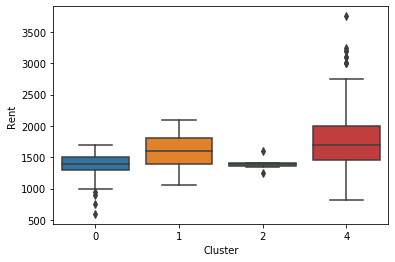

In [104]:
sns.boxplot(x="Cluster", y="Rent", data=rental_with_cluster)

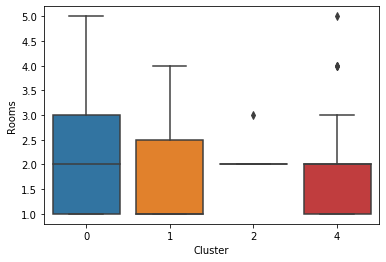

In [105]:
sns.boxplot(x="Cluster", y="Rooms", data=rental_with_cluster)

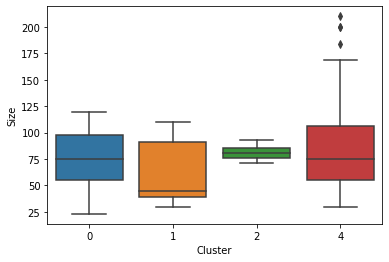

In [106]:
sns.boxplot(x="Cluster", y="Size", data=rental_with_cluster)

In [109]:
rental_suitable = rental_with_cluster[rental_with_cluster['Rent'] <= 1300]
rental_suitable = rental_suitable[rental_suitable['Rooms'] > 1]
rental_suitable = rental_suitable[rental_suitable['Size'] > 60]
rental_suitable.head()

,Title,Postcode,District,Street,Type,Size,Rooms,Furnished,Neighborhoodr,SLatitude,SLongitude,Rent,Distance,Cluster
35,Arthur van Schendelstraat,3511MZ,Wijk 06 Binnenstad,Carry van Bruggenstraat,Apartment,75,2,upholstered,Binnenstad,52.083785,5.117154,1295,0.0444714,4
118,Rolderdiephof,3521DA,Wijk 08 Zuidwest,Rolderdiephof,Apartment,80,2,furnished,Zuidwest,52.081562,5.107654,1215,0.275886,4
133,Aziëlaan,3526SJ,Wijk 08 Zuidwest,Aziëlaan,Apartment,73,2,upholstered,Zuidwest,52.066170,5.104754,1250,0.612787,0
134,Aziëlaan276,3526SJ,Wijk 08 Zuidwest,Aziëlaan,Apartment,102,3,shell,Zuidwest,52.066170,5.104754,950,0.612787,0
141,Van Vollenhovenlaan,3527JA,Wijk 08 Zuidwest,Van Vollenhovenlaan,Apartment,77,2,upholstered,Zuidwest,52.078419,5.094106,1250,0.40951,2


In [110]:
cluster_map = folium.Map(
    location=[latitude, longitude],
    tiles='Stamen Toner',
    zoom_start=13,
    width =800
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(utrecht_merged['Latitude'], utrecht_merged['Longitude'], utrecht_merged['Neighborhood'], utrecht_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=.2).add_to(cluster_map)

# add markers to map
for lat, lng, label, post, clust in zip(rental_suitable['SLatitude'], rental_suitable['SLongitude'], rental_suitable['Title'], rental_suitable['Postcode'], rental_with_cluster['Cluster']):
    label = folium.Popup(label+' '+post, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue',icon='glyphicon glyphicon-home')
        ).add_to(cluster_map)


cluster_map